In [10]:
# Cell 1: Load
import sys
sys.path.append('../src')

from data_loader import fetch_data
from eda import (
    audit_dataframe, handle_missing_values, get_price_columns,
    calculate_daily_returns, zscore_scale,
    plot_prices, plot_daily_returns, plot_rolling_stats,
    flag_outliers_zscore, list_extreme_days,
    analyze_stationarity
)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display  # ensure display() is available

# Ensure directories
for p in ["../data/raw", "../data/processed", "../images"]:
    Path(p).mkdir(parents=True, exist_ok=True)

tickers = ['TSLA', 'BND', 'SPY']
start_date = '2015-07-01'
end_date   = '2025-07-31'

# Extract data
data = fetch_data(tickers, start_date, end_date, auto_adjust=False, progress=False)
data.to_csv('../data/raw/stock_data_raw.csv')

if data.empty:
    raise ValueError("No data returned. Check tickers, dates, or network connectivity.")

In [11]:
# Cell 2: Clean and understand
print("Data audit (dtypes & missing):")
display(audit_dataframe(data))

# Price-level stats with robust fallback
price_cols = get_price_columns(data, prefer_adjusted=True)
print("Detected price columns:", price_cols)

if not price_cols:
    # Fallback to show user what's present
    print("⚠️ No 'Adj Close_' or 'Close_' columns detected. Available columns:")
    print(list(data.columns))
else:
    print("Basic statistics for prices:")
    display(data[price_cols].describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]))

# Handle missing values (choose: 'ffill_bfill', 'interpolate', 'drop')
data = handle_missing_values(data, method="ffill_bfill")
data.to_csv('../data/processed/stock_data_processed.csv')

Data audit (dtypes & missing):


,dtype,missing,non_null
Open_BND,float64,0,2535
High_BND,float64,0,2535
Low_BND,float64,0,2535
Close_BND,float64,0,2535
Adj Close_BND,float64,0,2535
Volume_BND,int64,0,2535
Open_SPY,float64,0,2535
High_SPY,float64,0,2535
Low_SPY,float64,0,2535
Close_SPY,float64,0,2535


Detected price columns: ['Adj Close_BND', 'Adj Close_SPY', 'Adj Close_TSLA']
Basic statistics for prices:


,Adj Close_BND,Adj Close_SPY,Adj Close_TSLA
count,2535.000000,2535.000000,2535.000000
mean,68.469189,334.193734,131.963002
std,4.554600,126.427704,120.914904
min,60.779186,155.869843,9.578000
1%,61.333434,162.891503,12.368000
5%,61.955029,174.955119,13.749533
50%,67.604881,305.264435,94.571335
95%,76.361580,580.422687,340.566003
99%,76.761160,607.607744,404.341603
max,77.318260,637.099976,479.859985


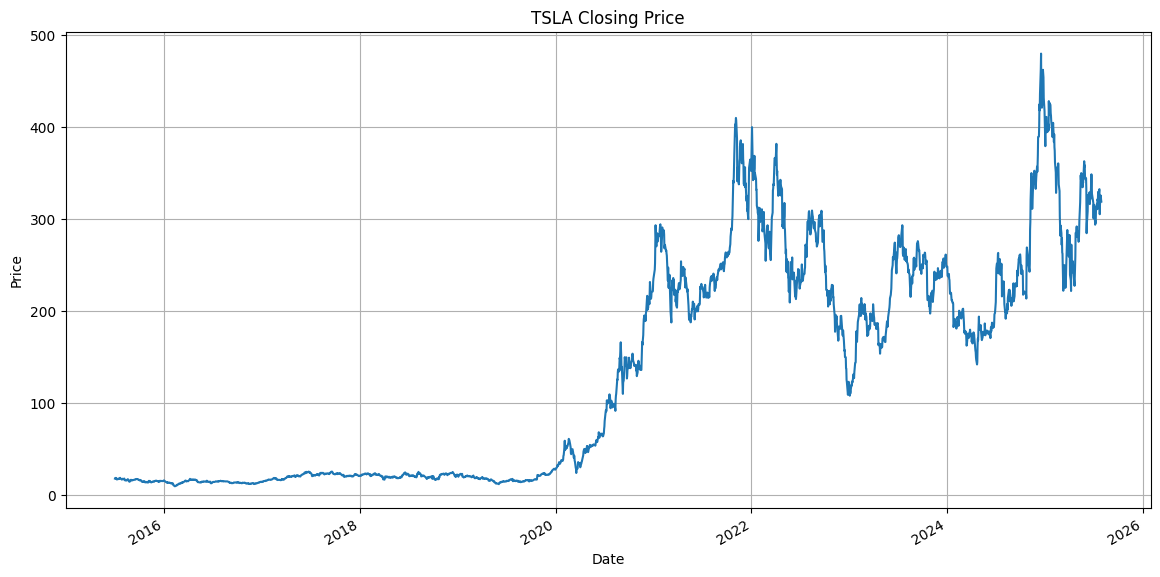

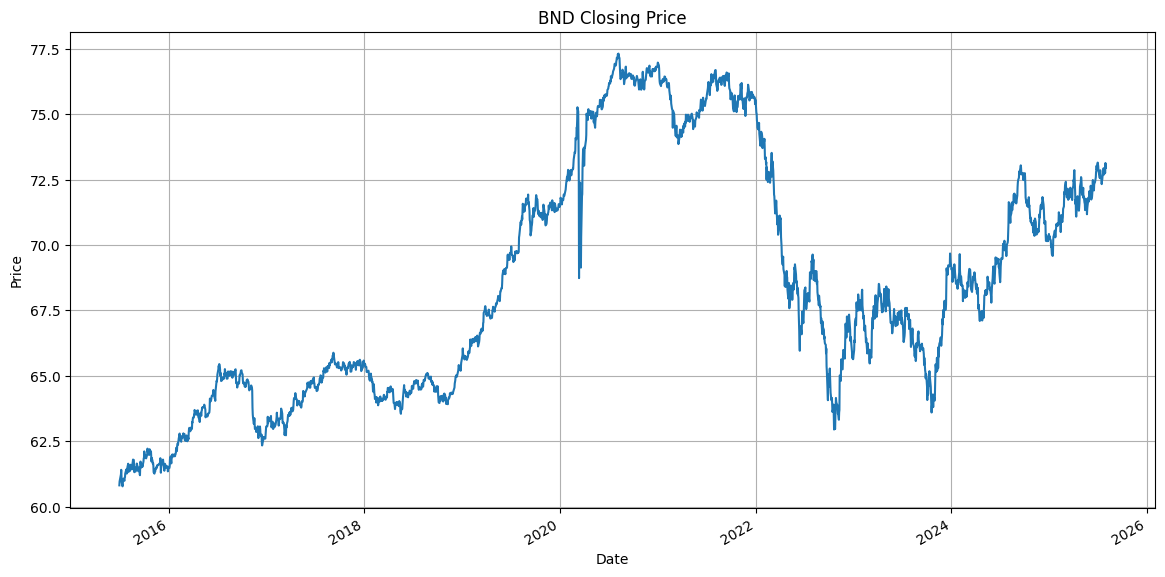

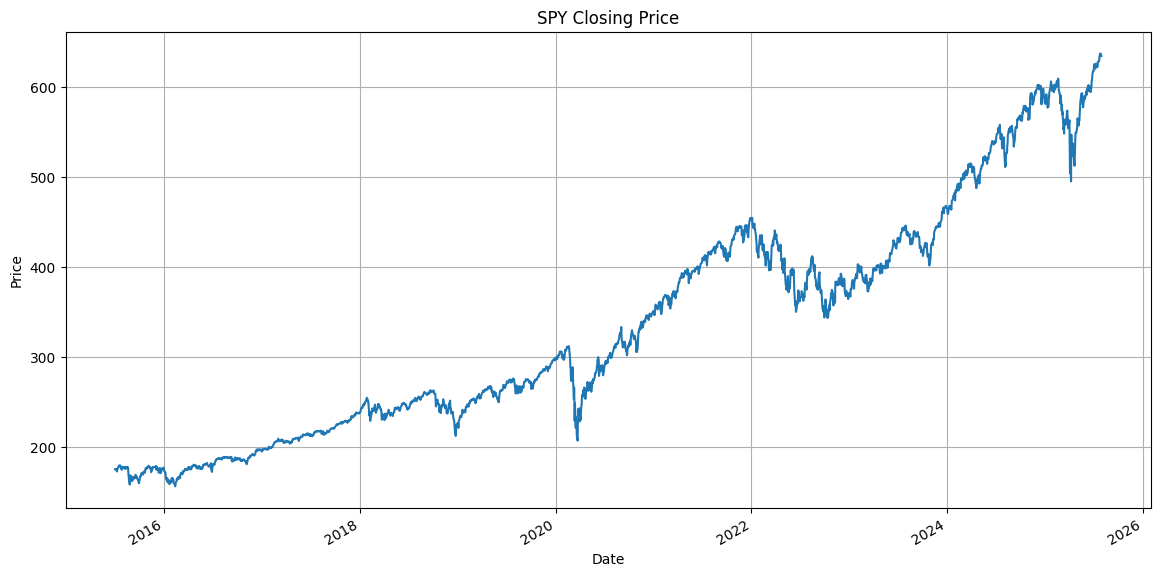

In [12]:
# Cell 3: EDA — visualize closing prices
for t in tickers:
    try:
        plot_prices(data, t, prefer_adjusted=True)
    except KeyError as e:
        print(f"⚠️ Skipping price plot for {t}: {e}")

Basic statistics for daily returns:


,Adj Close_BND,Adj Close_SPY,Adj Close_TSLA
count,2534.000000,2534.000000,2534.000000
mean,0.000078,0.000575,0.001828
std,0.003460,0.011491,0.037285
min,-0.054385,-0.109424,-0.210628
1%,-0.008785,-0.033143,-0.092736
5%,-0.004900,-0.017195,-0.054663
50%,0.000127,0.000645,0.001261
95%,0.004726,0.016055,0.059938
99%,0.008360,0.026676,0.109964
max,0.042201,0.105019,0.226900


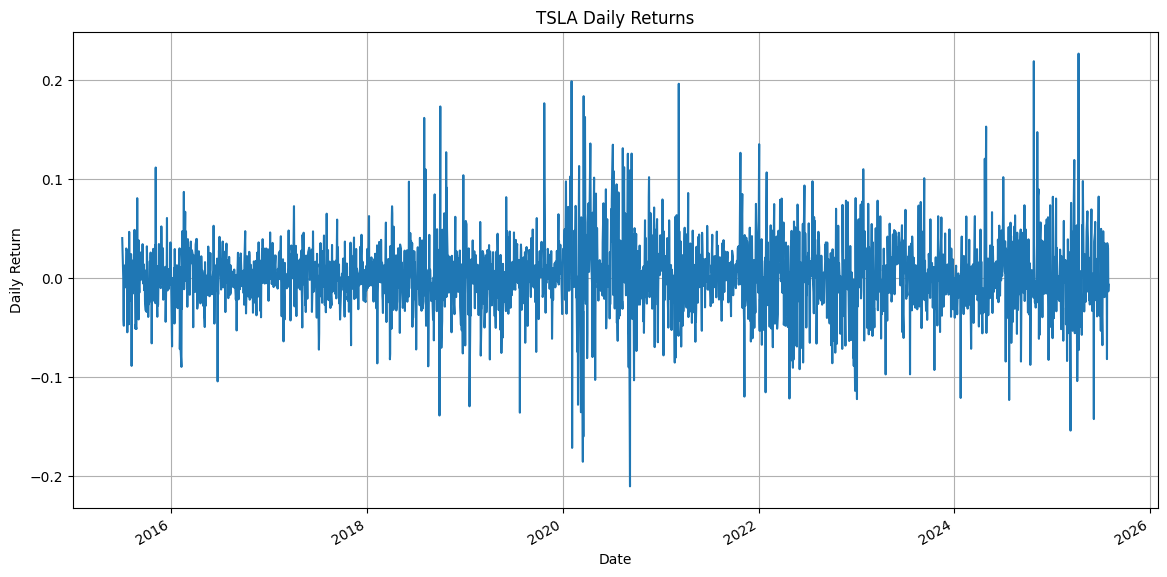

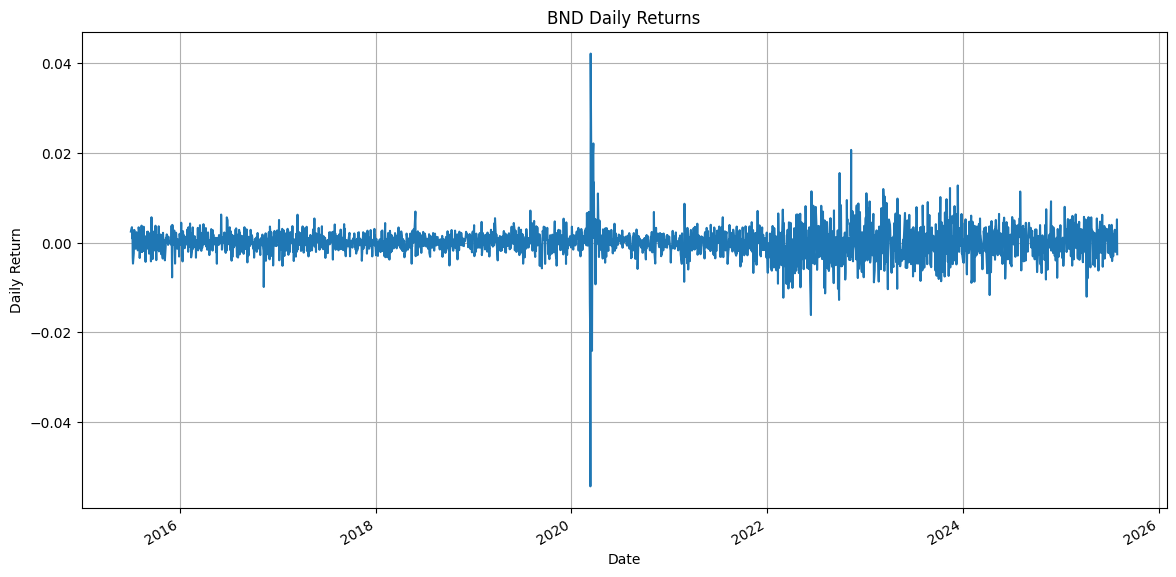

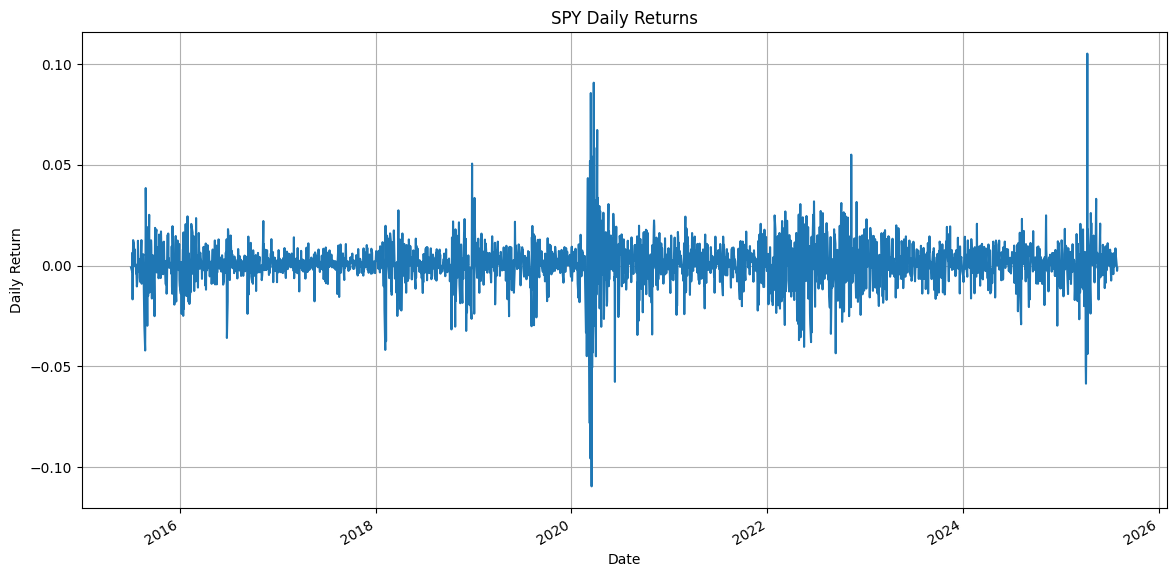

In [13]:
# Cell 4: EDA — daily percentage change (returns)
daily_returns = calculate_daily_returns(data, prefer_adjusted=True)

if daily_returns.empty:
    raise ValueError("Daily returns are empty — price columns likely missing. Inspect previous cell output.")

print("Basic statistics for daily returns:")
display(daily_returns.describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]))
daily_returns.to_csv('../data/processed/daily_returns.csv')

for t in tickers:
    try:
        plot_daily_returns(daily_returns, t)
    except KeyError as e:
        print(f"⚠️ Skipping returns plot for {t}: {e}")

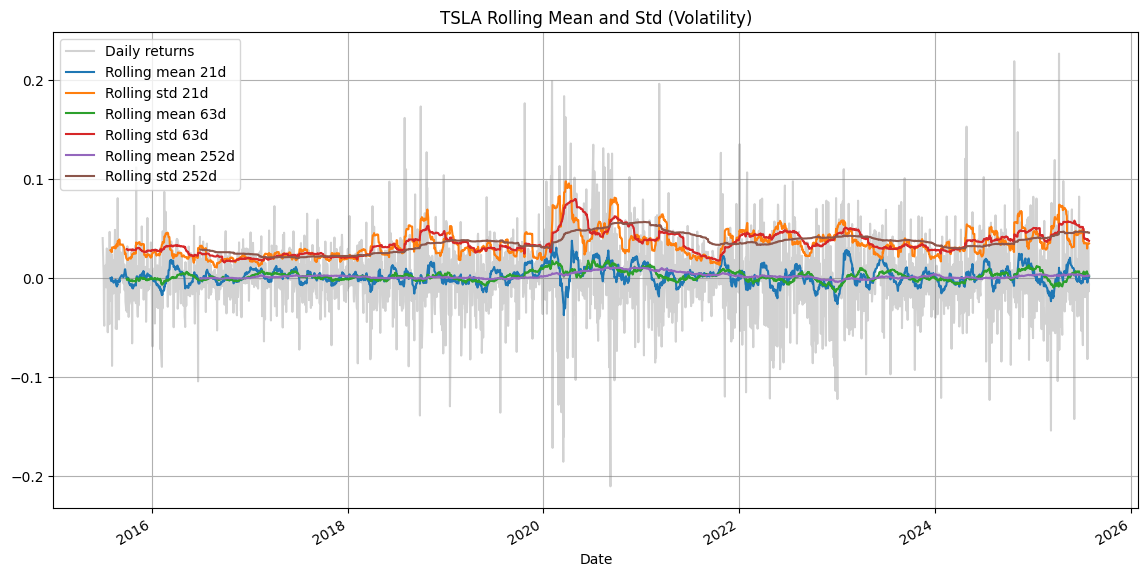

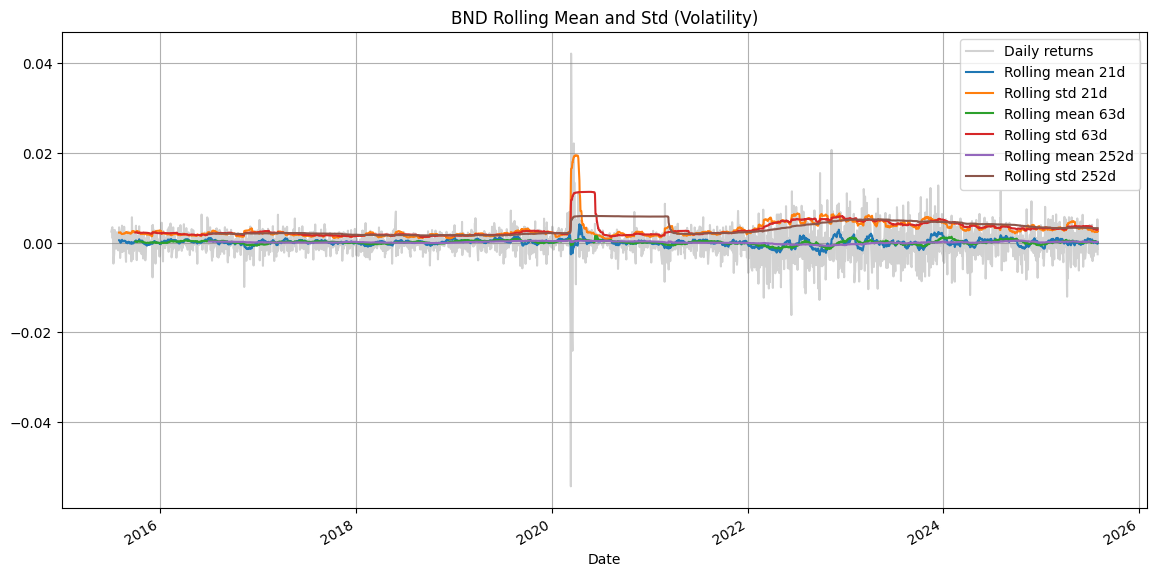

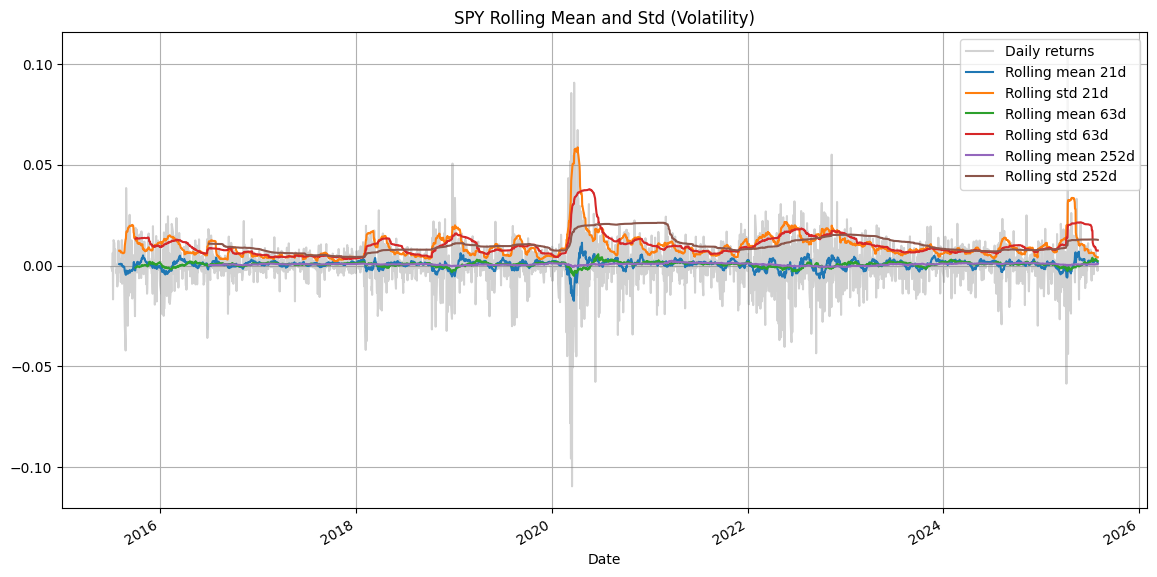

In [14]:
# Cell 5: EDA — analyze volatility via rolling mean and std
for t in tickers:
    try:
        plot_rolling_stats(daily_returns, t, windows=(21, 63, 252))
    except KeyError as e:
        print(f"⚠️ Skipping rolling stats for {t}: {e}")

In [16]:
# Cell 6: EDA — outlier detection and unusually high/low days
outlier_mask, zscores = flag_outliers_zscore(daily_returns, z_thresh=3.0)
print("Outlier counts per series (|z|>3):")
display(outlier_mask.sum())

extremes = list_extreme_days(daily_returns, q=0.01)
for t in tickers:
    cols = [c for c in daily_returns.columns if c.endswith(f"_{t}")]
    if not cols:
        print(f"⚠️ No returns column found for {t}")
        continue
    col = cols[0]
    print(f"\nUnusually high days (top 1%) for {t}: {len(extremes['highs'].get(col, []))}")
    print(f"Unusually low days (bottom 1%) for {t}: {len(extremes['lows'].get(col, []))}")

Outlier counts per series (|z|>3):


Adj Close_BND     26
Adj Close_SPY     35
Adj Close_TSLA    41
dtype: int64


Unusually high days (top 1%) for TSLA: 26
Unusually low days (bottom 1%) for TSLA: 26

Unusually high days (top 1%) for BND: 26
Unusually low days (bottom 1%) for BND: 26

Unusually high days (top 1%) for SPY: 26
Unusually low days (bottom 1%) for SPY: 26


In [17]:
# Cell 7: Seasonality & trends — ADF on prices and returns
# Prices
for t in tickers:
    price_col = f"Adj Close_{t}" if f"Adj Close_{t}" in data.columns else f"Close_{t}"
    if price_col in data.columns:
        analyze_stationarity(data[price_col], f"{t} Price")
    else:
        print(f"⚠️ Skipping ADF on {t} price: no price column found.")

# Returns
for t in tickers:
    cols = [c for c in daily_returns.columns if c.endswith(f"_{t}")]
    if cols:
        analyze_stationarity(daily_returns[cols[0]], f"{t} Daily Returns")
    else:
        print(f"⚠️ Skipping ADF on {t} returns: no returns column found.")


📊 ADF for TSLA Price | ADF=-1.4189, p=0.5732
⚠️ Non-stationary: differencing (the 'I' in ARIMA) is required before modeling.

📊 ADF for BND Price | ADF=-1.5363, p=0.5155
⚠️ Non-stationary: differencing (the 'I' in ARIMA) is required before modeling.

📊 ADF for SPY Price | ADF=0.6908, p=0.9897
⚠️ Non-stationary: differencing (the 'I' in ARIMA) is required before modeling.

📊 ADF for TSLA Daily Returns | ADF=-34.6811, p=0.0000
✅ Stationary: differencing likely not required for this series.

📊 ADF for BND Daily Returns | ADF=-9.8898, p=0.0000
✅ Stationary: differencing likely not required for this series.

📊 ADF for SPY Daily Returns | ADF=-16.2644, p=0.0000
✅ Stationary: differencing likely not required for this series.


In [18]:
# Cell 8: Normalize/scale (for ML use) — z-score
returns_scaled = zscore_scale(daily_returns)
returns_scaled.to_csv('../data/processed/daily_returns_zscore.csv')
print("Scaled returns (z-score) saved for ML workflows.")

Scaled returns (z-score) saved for ML workflows.


In [19]:
# Cell 9: Key insights & risk metrics (VaR and Sharpe)
risk_free_rate = 0.02  # annual

def cagr(prices: pd.Series) -> float:
    p = prices.dropna()
    if len(p) < 2:
        return np.nan
    years = (p.index[-1] - p.index[0]).days / 365.25
    return (p.iloc[-1] / p.iloc[0]) ** (1/years) - 1 if years > 0 else np.nan

# Tesla direction (CAGR)
tsla_col = "Adj Close_TSLA" if "Adj Close_TSLA" in data.columns else "Close_TSLA"
tsla_cagr = cagr(data[tsla_col]) if tsla_col in data.columns else np.nan

# Volatility & outliers
vol_annual = daily_returns.std() * np.sqrt(252)
outliers_count = (np.abs((daily_returns - daily_returns.mean()) / daily_returns.std(ddof=0)) > 3).sum()

# Risk metrics
mu_daily = daily_returns.mean()
sigma_daily = daily_returns.std()
sharpe_annual = ((mu_daily * 252) - risk_free_rate) / (sigma_daily * np.sqrt(252))
VaR_95_daily = -daily_returns.quantile(0.05)  # positive potential loss

print(f"Tesla direction (CAGR): {tsla_cagr:.2%}" if not np.isnan(tsla_cagr) else "Tesla direction (CAGR): N/A")
print("\nAnnualized volatility:")
display(vol_annual.sort_values(ascending=False))
print("Outlier counts (|z|>3):")
display(outliers_count)
print("95% daily VaR (positive = potential loss):")
display(VaR_95_daily.sort_values(ascending=False))
print("Annualized Sharpe Ratio:")
display(sharpe_annual.sort_values(ascending=False))

Tesla direction (CAGR): 33.04%

Annualized volatility:


Adj Close_TSLA    0.591887
Adj Close_SPY     0.182407
Adj Close_BND     0.054919
dtype: float64

Outlier counts (|z|>3):


Adj Close_BND     26
Adj Close_SPY     35
Adj Close_TSLA    41
dtype: int64

95% daily VaR (positive = potential loss):


Adj Close_TSLA    0.054663
Adj Close_SPY     0.017195
Adj Close_BND     0.004900
Name: 0.05, dtype: float64

Annualized Sharpe Ratio:


Adj Close_TSLA    0.744550
Adj Close_SPY     0.684427
Adj Close_BND    -0.007296
dtype: float64